Assess performance of the Bayesian Mixture models with different datasets, variables and parameter values

In [126]:
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
import pandas as pd 
from matplotlib import pyplot as plt
# from rdt.transformers import BayesGMMTransformer ## <-- implementation of the BGMM in the version of rdt in this package

In [127]:
data_map = {
    "adult": {
        "path": "../datasets/Adult/Real/real_adult_data.csv",
        "numvars": ["fnlwgt", "hours-per-week", "education-num", "age", "capital-gain", "capital-loss"] 
    },
    "census": {
        "path": "../datasets/Census/Real/real_census_data.csv",
        "numvars": ["age", "wage per hour", "capital gains", "capital losses", "dividends from stocks", "num persons worked for employer", "weeks worked in year"]
    },
    "intrusion": {
        "path": "../datasets/Intrusion/Real/real_intrusion_data.csv",
        "numvars": ["duration", "src_bytes", "dst_bytes", "wrong_fragment", "hot", "num_failed_logins",
                    "num_compromised", "num_root", "num_file_creations", "num_access_files",
                    "count", "srv_count", "serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                    "diff_srv_rate", "srv_diff_host_rate"]
    }
}

In [128]:
# set parameters here 
use_dataset = "adult"
sample_size = 100_000

Load data

In [129]:
data = pd.read_csv(data_map[use_dataset]["path"])
if "Unnamed: 0" in data.columns:
    data = data.drop(columns=["Unnamed: 0"])

sample_size = min(data.shape[0], sample_size)
data = data.sample(n=sample_size)
data.describe()


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [130]:
varnames = data_map[use_dataset]["numvars"]
n = len(varnames)

In [131]:
[v for v in varnames if v not in data.columns]

[]

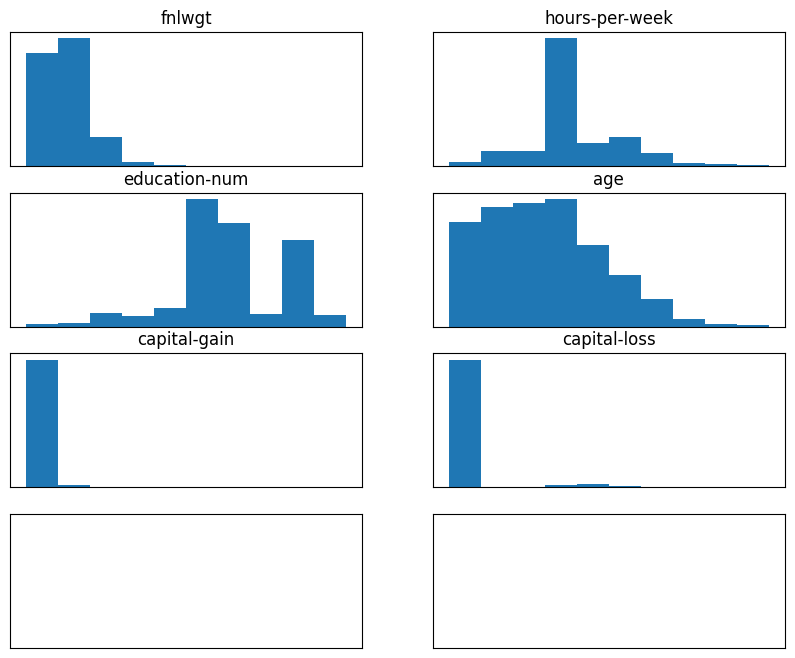

In [132]:
nrows = 4
if n % nrows == 0:
    ncols = n / nrows 
else:    # print((rowid, colid))
    ncols = n// nrows + 1
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 8))

rowid = 0 
colid = 0
# Iterate over columns and rows to plot
for i in range(ncols*nrows):
    ax = axs[rowid, colid]

    if i < len(varnames):
        v = varnames[i]
        ax.hist(data[v])
        ax.title.set_text(v)  

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    if colid < ncols-1:
        colid += 1
    else:
        rowid += 1
        colid = 0
        



In [133]:
print(varnames)

['fnlwgt', 'hours-per-week', 'education-num', 'age', 'capital-gain', 'capital-loss']


In [134]:
varname = "age"
data[varname].describe()

count    30162.000000
mean        38.437902
std         13.134665
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64

In [135]:

def fit_gmm(x, init_params="random", covariance_type="full", n_init=5):
    gm = GaussianMixture(
        n_components=3,
        covariance_type=covariance_type,
        n_init=n_init , #10
        max_iter=2000, #1000
        warm_start=True,
        init_params=init_params,
    )
    gm.fit(x.reshape(-1, 1))

    valid_component_indicator = gm.weights_
    # num_components = valid_component_indicator.sum()

    return valid_component_indicator



def fit_bgmm(x, init_params="random", covariance_type="full", n_init=5):
    gm = BayesianGaussianMixture(
        n_components=3,
        covariance_type=covariance_type,
        weight_concentration_prior_type='dirichlet_process',  # special for B-GMM
        weight_concentration_prior=1e-3, # special
        n_init=n_init , #10
        max_iter=2000, #1000
        warm_start=True,
        init_params=init_params,
    )
    gm.fit(x.reshape(-1, 1))

    valid_component_indicator = gm.weights_
    # num_components = valid_component_indicator.sum()

    return valid_component_indicator

def sequential_function(data, variables, init_params="random"):
    output = []
    for v in variables:
        x = data[v].values
        output.append(fit_bgmm(x, init_params=init_params))
    return output 
    


### Notes 
- The routine uses all CPU cores already

### Performance on a single variable

(30162, 15)

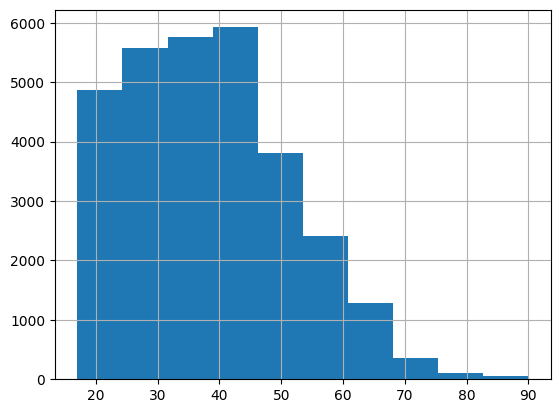

In [136]:
data[varname].hist()
data.shape

In [83]:
display(fit_bgmm(x=data[varname].values))
display(fit_bgmm(x=data[varname].values, init_params="kmeans"))
display(fit_bgmm(x=data[varname].values, n_init=1))

# display(fit_gmm(data[varname].values)) 

array([0.49456284, 0.34564865, 0.1597885 ])

array([0.49460268, 0.34562005, 0.15977727])

array([0.16033597, 0.34643377, 0.49323026])

In [44]:
%timeit -r 1 -n 1 fit_bgmm(data[varname].values)

3.28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [45]:
%timeit -r 1 -n 1 fit_bgmm(data[varname].values, "kmeans") 

4.78 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### Comparing performance `init_params="kmeans"` vs `init_params="random"`
- No clear winner, but
    - it seems kmeans is often around the same speed (for "easy" variables with a single mode, or two clearly different modes) and faster for more difficult variables 
    - in particular, the "fnlwgt" and "age" variables in the datasets are those that take longer to fit, and here kmeans reaches a speedup of up to 50-60%
- CTGAN uses the default initialization, which is "kmeans"
- We're using version 0.24 of `scikit-learn`; however, the latest version is 1.3.1. It has more options, but I'm not sure it has an impact on performance
    - https://scikit-learn.org/stable/modules/mixture.html#mixture: `kmeans++` may be faster
- **Question**: how does this scale with the number of rows?
    - 30'000 rows is still quite a small dataset


#### Role of covariance type

In [140]:
%timeit -r 10 -n 1 fit_bgmm(data[varname].values, init_params="random", covariance_type="diag") 

15.5 s ± 3.52 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [55]:
%timeit -r 10 -n 1 fit_bgmm(data[varname].values, init_params="random", covariance_type="full") 

17.2 s ± 1.87 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [84]:
%timeit -r 10 -n 1 fit_bgmm(data[varname].values, init_params="random", covariance_type="full", n_init=1) 

3.28 s ± 482 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


Notes
- for adult: "hours-per-week" is easy to fit, "age" is not 
- for "age", init_params="random" and covariance_type "diag" takes 15.7s, with covariance_type "full" it takes 17.2s.

### Check the number of iterations


In [156]:
gm = BayesianGaussianMixture(
        n_components=5,
        covariance_type="full",
        weight_concentration_prior_type='dirichlet_process',  # special for B-GMM
        weight_concentration_prior=1e-3, # special
        n_init=1 , #10
        max_iter=2000, #1000
        warm_start=True,
        init_params="random",
    )

In [157]:
model = gm.fit(data[varname].values.reshape(-1, 1))

In [158]:
model.n_iter_

1775

In [159]:
model.weights_

array([0.17643997, 0.05104389, 0.09223491, 0.32013609, 0.36014513])

### Performance on multiple variables, sequentially

In [22]:
# %timeit sequential_function(data, varnames)

8.44 s ± 824 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
